In [134]:
import photutils
import os
import sys
import numpy as np

import astropy
from astropy.visualization import SqrtStretch, LogStretch
from photutils import detect_threshold
from astropy.io import fits
from astropy.wcs import WCS
from astropy.modeling.fitting import LevMarLSQFitter
from astropy.modeling.functional_models import Gaussian2D

from pyspark.sql.types import Row
from pyspark import SparkContext
from pyspark.sql import SparkSession

from astropy.visualization.mpl_normalize import ImageNormalize
from astropy.convolution import Gaussian2DKernel
from astropy.stats import gaussian_fwhm_to_sigma
from photutils import detect_sources
import time
import matplotlib.pyplot as plt

import shutil
from math import pi, log, sqrt

import warnings
warnings.filterwarnings("ignore")

In [135]:
# Define data paths
DR2_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2/"
mosaic_path = "/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/"

In [136]:
# Take a look at the data in a .fits file
hdul = fits.open(mosaic_path + "P004+38_mosaic-blanked.fits")
data = hdul[0].data # The intensity data
print(hdul[0].__dict__)

{'_header_str': None, '_file': <astropy.io.fits.file._File <_io.FileIO name='/data/astronomy-big-data/bc96e9620e41b9aba98292d37b5eec24/LoTSS_DR2_mosaic/P004+38_mosaic-blanked.fits' mode='rb' closefd=True>>, '_buffer': None, '_header_offset': 0, '_data_offset': 2880, '_data_size': 735744960, '_data_replaced': False, '_data_needs_rescale': False, '_new': False, '_output_checksum': False, '_checksum': None, '_checksum_valid': None, '_datasum': None, '_datasum_valid': None, '_do_not_scale_image_data': False, '_uint': True, '_scale_back': None, '_bzero': 0, '_bscale': 1, '_axes': [9590, 9590], '_bitpix': -64, '_gcount': 1, '_pcount': 0, '_blank': None, '_orig_bitpix': -64, '_orig_blank': None, '_orig_bzero': 0, '_orig_bscale': 1, '_modified': False, '_header': SIMPLE  =                    T / conforms to FITS standard                      
BITPIX  =                  -64 / array data type                                
NAXIS   =                    2 / number of array dimensions             

In [137]:
print(hdul[0]._header['OBJECT'])
print(hdul[0].header['OBJECT'])

P004+38
P004+38


In [140]:
# Import the .fits file header in the WCS class and create WCS based on the pixels
w = WCS(hdul[0].header)
ra, dec = w.all_pix2world(30, 40, 0, ra_dec_order=True)
print(ra, dec)

6.72375366193755 36.48412544031272


In [141]:
# Define noise threshold
threshold = detect_threshold(data, nsigma=3.)

In [ ]:
print(threshold)

In [ ]:
# Sigma?
sigma = 3.0 * gaussian_fwhm_to_sigma  # FWHM = 3.
# Use kernel (3x3) to find borders of sources
kernel = Gaussian2DKernel(sigma, x_size=3, y_size=3)
kernel.normalize()
# sources = object with label of sources for each pixel in the fits file
sources = detect_sources(data, threshold, npixels=5, filter_kernel=kernel)

In [ ]:
# Create nice figure
norm = ImageNormalize(stretch=LogStretch())
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 12.5))
ax1.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
ax1.set_title('Data')
cmap = sources.make_cmap(random_state=12345)
ax2.imshow(sources, origin='lower', cmap=cmap)
ax2.set_title('Segmentation Image')

In [ ]:
print(hdul[0]._header['NAXIS1'])
print(hdul[0]._header['NAXIS2'])
x = hdul[0]._header['NAXIS1']
y = hdul[0]._header['NAXIS2']

plt.figure(figsize=(x/1000, y/1000), dpi=100)
plt.imshow(data, origin='lower', cmap='Greys_r', norm=norm)
plt.savefig('test_mosaic.png', dpi=1000)

In [ ]:
# Content of the labelled sources
sources.__dict__

In [ ]:
def create_sub_matrices(hdul, sources, s=10):
    # data = hdul.data[:s*10]
    data = hdul.data
    min_max_coords = np.full((sources.max_label, 2, 2), ((np.inf, np.inf), (-np.inf, -np.inf)))
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            lab = sources.data[i, j] - 1  # Label of pixel i,j
            if lab + 1 != 0:
                # Define min max coords
                min_coords = min_max_coords[lab][0]
                max_coords = min_max_coords[lab][1]
                # Check if smallest x coordinate
                if i < min_coords[0]:
                    min_coords[0] = i
                # Check if biggest x coordinate
                elif i > max_coords[0]:
                    max_coords[0] = i
                # Check if smallest y coordinate
                if j < min_coords[1]:
                    min_coords[1] = j
                # Check if biggest y coordinate
                elif j > max_coords[1]:
                    max_coords[1] = j
    
    min_max_coords = min_max_coords.astype(int)
    source_intensities = []
    for i in range(len(min_max_coords)):
        # Define min and max coords
        min_coords = min_max_coords[i][0]
        max_coords = min_max_coords[i][1] + 1
        # Mask of labels
        mask = sources.data[min_coords[0]:max_coords[0],
                            min_coords[1]:max_coords[1]]
        # Only take labels of current source and factor it against the intensities
        source_intensities.append((mask == i+1) * data[min_coords[0]:max_coords[0],
                                                       min_coords[1]:max_coords[1]])
    return min_max_coords, np.array(source_intensities)

In [ ]:
start = time.time()
min_max_coords, source_intensities = create_sub_matrices(hdul[0], sources)
print(time.time()-start)

In [ ]:
def create_catalogue_submatrix(coords, mat, conv, w, deconv, plot=True):
    
    # Define min and max coords
    min_coords = coords[0]
    max_coords = coords[1]
    
    # matrix filled with index values so first row for x = [0, 1, 2, ...] and y = [0, 0, 0, ..]
    # Used to fit gaussian and to calculate norm center of mass
    y, x = np.mgrid[:mat.shape[0], :mat.shape[1]]
    
    # Get num pixels
    total_pixels = np.sum(mat > 0)
    
    # Get sum intensity
    sum_mat = np.sum(mat)
    integrated_intensity = conv * sum_mat
    
    # Brightest pixel (account for local submatrix coordinates)
    brightest_pixel_x, brightest_pixel_y = np.unravel_index(np.argmax(mat, axis=None), mat.shape)
    brightest_pixel = mat[(brightest_pixel_x, brightest_pixel_y)]
    brightest_pixel_x += min_coords[0] # Add the min x coord of source
    brightest_pixel_y += min_coords[1] # Add the min y coord of source
    brightest_pixel_RA, brightest_pixel_DEC = w.all_pix2world(brightest_pixel_x,
                                                              brightest_pixel_y, 0, ra_dec_order=True)
    
    # center of mass = sum(( coords(x, y) * mat(inten) )) / integrated_intensity
    center_of_mass_x, center_of_mass_y = np.sum(np.sum(np.array(( (x + min_coords[0]),
                                                                  (y + min_coords[1]) )) * mat, axis=1), axis=1) / sum_mat 
    # center_of_mass_x = np.sum(np.dot((x + min_coords[0]).T, mat)) / integrated_intensity
    # center_of_mass_y = np.sum(np.dot((y + min_coords[1]).T, mat)) / integrated_intensity
    # center_of_mass_x = np.sum(np.sum((x + min_coords[0]) * mat, axis=1)) / sum_mat
    # center_of_mass_y = np.sum(np.sum((y + min_coords[1]) * mat, axis=1)) / sum_mat
    
    # center_of_mass = np.around(center_of_mass, 0).astype(int)

    center_of_mass_RA, center_of_mass_DEC = w.all_pix2world(center_of_mass_x,
                                                            center_of_mass_y, 0, ra_dec_order=True)
    
    # Define parameters of gaussian
    x_m = center_of_mass_x - min_coords[0]
    y_m = center_of_mass_y - min_coords[1]
    x_s = max_coords[0] - min_coords[0]
    y_s = max_coords[1] - min_coords[1]
    
    # Define model
    mod = astropy.modeling.functional_models.Gaussian2D(
        amplitude=brightest_pixel, # Max intensity of source
        x_mean=x_m,    # X center of mass
        y_mean=y_m,    # Y center of mass
        x_stddev=x_s,  # X of submatrix
        y_stddev=y_s   # Y of submatrix
    )
    
    # Setting resutrictions for model
    mod.x_mean.min=0   # x_mean Min = 0
    mod.y_mean.min=0   # y_mean Min = 0
    mod.x_mean.max=x_s # x_mean Max = X of submatrix
    mod.y_mean.max=y_s # y_mean Max = Y of submatrix

    mod.x_stddev.min=0   # x_stdv Min = 0
    mod.y_stddev.min=0   # y_stdv Min = 0
    mod.x_stddev.max=x_s # x_stdv Max = X of submatrix
    mod.y_stddev.max=y_s # y_stdv Max = Y of submatrix
    
    fitter = astropy.modeling.fitting.LevMarLSQFitter() # Use least square fitter
    
    best_fit_gauss = fitter(mod, x, y, mat) # Fit model

    # Define centers of gaussian fit
    center_of_gaus_fit_x = best_fit_gauss.x_mean.value + min_coords[0]
    center_of_gaus_fit_y = best_fit_gauss.y_mean.value + min_coords[1]
    center_of_gaus_fit_RA, center_of_gaus_fit_DEC = w.all_pix2world(center_of_gaus_fit_x,
                                                                    center_of_gaus_fit_y, 0, ra_dec_order=True)
    
    # Define axis and theta of fit
    fit_x_axis = best_fit_gauss.x_stddev.value
    fit_y_axis = best_fit_gauss.y_stddev.value
    fit_theta  = best_fit_gauss.theta.value
            
    deconv_x = deconv(fit_x_axis)
    deconv_y = deconv(fit_y_axis)
    
    print('x axis:', x_s)
    print('y axis:', y_s)
    print('fit x axis:', fit_x_axis)
    print('fit y axis:', fit_y_axis)
    print('angle:', fit_theta)
    print('deconv x:', deconv_x)
    print('deconv y:', deconv_y)
    
    # Integrated intensity of fit
    integrated_intensity_fit = conv * np.sum(best_fit_gauss(x, y))
    
    # Residual / Source (sum intensities)
    ratio_residual = np.sum((mat - best_fit_gauss(x, y)).clip(min=0)) / sum_mat
    
    if plot == True:
        # Plot the data with the best-fit model
        plt.figure(figsize=(8, 2.5))
        plt.subplot(1, 4, 1)
        plt.imshow(mat, origin='lower', interpolation='nearest')
        plt.title("Data")
        plt.subplot(1, 4, 2)
        plt.imshow(mod(x, y), origin='lower', interpolation='nearest')
        plt.title("Model")
        plt.subplot(1, 4, 3)
        plt.imshow(best_fit_gauss(x, y), origin='lower', interpolation='nearest')
        plt.title("Fit")
        plt.subplot(1, 4, 4)
        plt.imshow((mat - best_fit_gauss(x, y)).clip(min=0), origin='lower', interpolation='nearest')
        plt.title("Residual")
    
    return np.array((integrated_intensity, brightest_pixel, brightest_pixel_x, brightest_pixel_y,
                     brightest_pixel_RA, brightest_pixel_DEC, center_of_mass_x, center_of_mass_y,
                     center_of_mass_RA, center_of_mass_DEC, center_of_gaus_fit_x, center_of_gaus_fit_y,
                     center_of_gaus_fit_RA, center_of_gaus_fit_DEC, fit_x_axis, fit_y_axis, fit_theta,
                     integrated_intensity_fit, ratio_residual))

In [178]:
index = 200
diameter_beam = hdul[0].header['BMAJ'] * 3600
conversion = pi * pow(diameter_beam, 2) / (4 * log(2))
deconv = lambda axis: sqrt( (pow( axis * 2 * sqrt(2 * log(2)), 2) - 16).clip(min=0) )

x axis: 4
y axis: 7
fit x axis: 1.0788118903526427
fit y axis: 4.862080230522729
angle: 1.0305444680341551
deconv x: 0.0
deconv y: 10.727861845124496
0.176971435546875


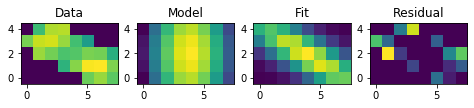

In [179]:
start = time.time()
sub_mat = create_catalogue_submatrix(min_max_coords[index], source_intensities[index], conversion, w, deconv)
print(time.time()-start)

In [68]:
sub_mat[-1]

0.05112104106225453

In [26]:
start = time.time()
for i in range(sources.max_label):
    stats_mat = create_catalogue_submatrix(min_max_coords[index], source_intensities[index], conversion, w)
print(time.time()-start)
stats_mat

NameError: name 'min_max_coords' is not defined

In [310]:
# The function to create the catalogue
def create_catalogue_data(hdul, sources):
    # Major beam axis in arc seconds
    header = fits.getheader(mosaic_path + "P004+38_mosaic-blanked.fits")
    diameter_beam = header['BMAJ'] * 3600
    conversion = pi * pow(diameter_beam, 2) / (4 * log(2))

    data = hdul.data
    w = WCS(hdul.header)
    v_pixel_to_wcs = np.vectorize(lambda a, b: w.all_pix2world(a, b, 0, ra_dec_order=True))
    
    integrated_intensity = np.zeros(sources.max_label)
    center_of_mass = np.zeros((sources.max_label, 2))
    brightest_pixel = np.zeros((sources.max_label, 5))
    
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            lab = sources.data[i, j] - 1  # Label of pixel i,j
            val = data[i, j]  # Intensity value of pixel i,j
            if lab + 1 != 0:
                integrated_intensity[lab] += val  # Sum for each label the intensity of each pixel
                center_of_mass[lab, :] += val * np.array([i, j])  # Sum the intensity times pixel position (i, j)
                if val > brightest_pixel[lab][0]:
                    # Keep the highest value per source
                    ra, dec = w.all_pix2world(i, j, 0, ra_dec_order=True)
                    brightest_pixel[lab] = np.array([val, i, j, ra, dec])
    
    # (pi * (Diameter_Beam)^2 / 4 * ln(2)) / (Pixel_Size)^2
    conv_integrated_intensity = conversion * integrated_intensity
    norm_center_of_mass = center_of_mass / np.array([conv_integrated_intensity, conv_integrated_intensity]).T
    norm_center_of_mass = norm_center_of_mass.astype(int)
    wc_norm_center_of_mass = np.array(v_pixel_to_wcs(norm_center_of_mass[:,0], norm_center_of_mass[:,1])).astype(int)
    
    return np.column_stack([
        np.arange(1, sources.max_label+1, dtype='int8'), # Source label
        integrated_intensity, # Integrated intensity   (intensity sum of each source)
        brightest_pixel[:,0], # Peak pixel intensity   (max intensity in each source)
        brightest_pixel[:,1], # x of peak pixel   (x of max intensity in each source)
        brightest_pixel[:,2], # y of peak pixel   (y of max intensity in each source)
        brightest_pixel[:,3], # RA of peak pixel  (RA of max intensity in each source)
        brightest_pixel[:,4], # DEC of peak pixel (DEC of max intensity in each source)
        norm_center_of_mass[:,0], # x pixel of norm center of mass
        norm_center_of_mass[:,1],  # y pixel of norm center of mass 
        wc_norm_center_of_mass[0], # Ra coords of norm center of mass
        wc_norm_center_of_mass[1] # Dec coords of norm center of masss
    ])

cat_matrix = create_catalogue_data(hdul[0], sources)

KeyboardInterrupt: 

In [27]:
cat_matrix[index]

NameError: name 'cat_matrix' is not defined

In [19]:
chunkest_source = sorted(np.unique(sources.data, return_counts=True)[1][1:], reverse=True)[80]
print(chunkest_source)
np.where(np.unique(sources.data, return_counts=True)[1] == chunkest_source)

501


(array([1869]),)

In [31]:
def create_sub_matrices(hdul, sources):
    data = hdul.data
    min_max_coords = np.full((sources.max_label, 2, 2), ((np.inf, np.inf), (-np.inf, -np.inf)))
    for i in range(np.shape(data)[0]):
        for j in range(np.shape(data)[1]):
            lab = sources.data[i, j] - 1  # Label of pixel i,j
            if lab + 1 != 0:
                # Define min max coords
                min_coords = min_max_coords[lab][0]
                max_coords = min_max_coords[lab][1]
                # Check if smallest x coordinate
                if i < min_coords[0]:
                    min_coords[0] = i
                # Check if biggest x coordinate
                elif i > max_coords[0]:
                    max_coords[0] = i
                # Check if smallest y coordinate
                if j < min_coords[1]:
                    min_coords[1] = j
                # Check if biggest y coordinate
                elif j > max_coords[1]:
                    max_coords[1] = j
    
    min_max_coords = min_max_coords.astype(int)
    all_sub_matrices = []
    
    for i in range(len(min_max_coords)):
        # Define min and max coords
        min_coords = min_max_coords[i][0]
        max_coords = min_max_coords[i][1] + 1
        # Mask of labels
        mask = sources.data[min_coords[0]:max_coords[0],
                            min_coords[1]:max_coords[1]]
        # Only take labels of current source and factor it against the intensities
        sub_matrix = (mask == i+1) * data[min_coords[0]:max_coords[0],
                                          min_coords[1]:max_coords[1]]
        
        label = hdul.header['OBJECT'] + '_' + str(i)
        
        all_sub_matrices.append(
            create_catalogue_submatrix(hdul, label, min_coords, max_coords, sub_matrix)
        )
    
    return all_sub_matrices

In [32]:
def create_catalogue_submatrix(hdul, label, min_coords, max_coords, mat):
    conv = pi * pow((hdul.header['BMAJ'] * 3600), 2) / (4 * log(2)) 
    w = WCS(hdul.header)
    
    # matrix filled with index values so first row for x = [0, 1, 2, ...] and y = [0, 0, 0, ..]
    # Used to fit gaussian and to calculate norm center of mass
    y, x = np.mgrid[:mat.shape[0], :mat.shape[1]]
    
    # Get sum intensity
    sum_mat = np.sum(mat)
    integrated_intensity = conv * sum_mat
    
    # Brightest pixel (account for local submatrix coordinates)
    brightest_pixel_x, brightest_pixel_y = np.unravel_index(np.argmax(mat, axis=None), mat.shape)
    brightest_pixel = mat[(brightest_pixel_x, brightest_pixel_y)]
    brightest_pixel_x += min_coords[0] # Add the min x coord of source
    brightest_pixel_y += min_coords[1] # Add the min y coord of source
    brightest_pixel_RA, brightest_pixel_DEC = w.all_pix2world(brightest_pixel_x,
                                                              brightest_pixel_y, 0, ra_dec_order=True)
    
    # center of mass = sum(( coords(x, y) * mat(inten) )) / integrated_intensity
    center_of_mass_x, center_of_mass_y = np.sum(np.sum(np.array(( (x + min_coords[0]),
                                                                  (y + min_coords[1]) )) * mat, axis=1), axis=1) / sum_mat 
    # center_of_mass_x = np.sum(np.dot((x + min_coords[0]).T, mat)) / integrated_intensity
    # center_of_mass_y = np.sum(np.dot((y + min_coords[1]).T, mat)) / integrated_intensity
    # center_of_mass_x = np.sum(np.sum((x + min_coords[0]) * mat, axis=1)) / sum_mat
    # center_of_mass_y = np.sum(np.sum((y + min_coords[1]) * mat, axis=1)) / sum_mat
    
    # center_of_mass = np.around(center_of_mass, 0).astype(int)

    center_of_mass_RA, center_of_mass_DEC = w.all_pix2world(center_of_mass_x,
                                                            center_of_mass_y, 0, ra_dec_order=True)
    
    # Define parameters of gaussian
    x_m = center_of_mass_x - min_coords[0]
    y_m = center_of_mass_y - min_coords[1]
    x_s = max_coords[0] - min_coords[0]
    y_s = max_coords[1] - min_coords[1]
    
    # Define model
    mod = Gaussian2D(
        amplitude=brightest_pixel, # Max intensity of source
        x_mean=x_m,    # X center of mass
        y_mean=y_m,    # Y center of mass
        x_stddev=x_s,  # X of submatrix
        y_stddev=y_s   # Y of submatrix
    )
    
    # Setting resutrictions for model
    mod.x_mean.min=0   # x_mean Min = 0
    mod.y_mean.min=0   # y_mean Min = 0
    mod.x_mean.max=x_s # x_mean Max = X of submatrix
    mod.y_mean.max=y_s # y_mean Max = Y of submatrix

    mod.x_stddev.min=0   # x_stdv Min = 0
    mod.y_stddev.min=0   # y_stdv Min = 0
    mod.x_stddev.max=x_s # x_stdv Max = X of submatrix
    mod.y_stddev.max=y_s # y_stdv Max = Y of submatrix
    
    fitter = LevMarLSQFitter() # Use least square fitter
    
    try:
        best_fit_gauss = fitter(mod, x, y, mat) # Fit model
    except:
        return (label, [integrated_intensity, brightest_pixel, brightest_pixel_x, brightest_pixel_y,
                        brightest_pixel_RA, brightest_pixel_DEC, center_of_mass_x, center_of_mass_y,
                        center_of_mass_RA, center_of_mass_DEC, 'NaN', 'NaN',
                        'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN', 'NaN']
       )
    
    # best_fit_gauss = fitter(mod, x, y, mat) # Fit model

    # Define centers of gaussian fit
    center_of_gaus_fit_x = best_fit_gauss.x_mean.value + min_coords[0]
    center_of_gaus_fit_y = best_fit_gauss.y_mean.value + min_coords[1]
    center_of_gaus_fit_RA, center_of_gaus_fit_DEC = w.all_pix2world(center_of_gaus_fit_x,
                                                                    center_of_gaus_fit_y, 0, ra_dec_order=True)
    
    # Define axis and theta of fit
    fit_x_axis = best_fit_gauss.x_stddev.value
    fit_y_axis = best_fit_gauss.y_stddev.value
    fit_theta  = best_fit_gauss.theta.value
    
    # Integrated intensity of fit
    integrated_intensity_fit = conv * np.sum(best_fit_gauss(x, y))
    
    # Residual / Source (sum intensities)
    ratio_residual = np.sum((mat - best_fit_gauss(x, y)).clip(min=0)) / sum_mat
    
    return (label, [integrated_intensity, brightest_pixel, brightest_pixel_x, brightest_pixel_y,
                    brightest_pixel_RA, brightest_pixel_DEC, center_of_mass_x, center_of_mass_y,
                    center_of_mass_RA, center_of_mass_DEC, center_of_gaus_fit_x, center_of_gaus_fit_y,
                    center_of_gaus_fit_RA, center_of_gaus_fit_DEC, fit_x_axis, fit_y_axis, fit_theta,
                    integrated_intensity_fit, ratio_residual]
           )

In [ ]:
start = time.time()
matrices = create_sub_matrices(hdul[0], sources)
print(time.time()-start)